# 实验六 相关分析与回归分析

In [1]:
import pandas as pd
import numpy as np
import statsmodels
import scipy.stats as sts
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']
plt.rcParams['axes.unicode_minus'] = False

##  1.例9-1
一家电器销售公司的管理人员收集了公司12月的月销售收入与电视广告费用的数据，提问：销售收入与电视广告费用之间是否存在一定的关系，关系有多大？

### 绘制散点图

In [2]:
data = pd.read_excel('第9章 相关与回归.xlsx',None)
df1 = data['表9-2']
df1.columns = ['月份','电视广告费用x','月销售收入y','x·y','y²','x²']
df1

,月份,电视广告费用x,月销售收入y,x·y,y²,x²
0,1,35,650,22750,422500,1225
1,2,30,591,17730,349281,900
2,3,28,570,15960,324900,784
3,4,18,540,9720,291600,324
4,5,21,570,11970,324900,441
5,6,24,564,13536,318096,576
6,7,17,520,8840,270400,289
7,8,21,565,11865,319225,441
8,9,32,595,19040,354025,1024
9,10,30,610,18300,372100,900


<AxesSubplot:xlabel='电视广告费用x', ylabel='月销售收入y'>

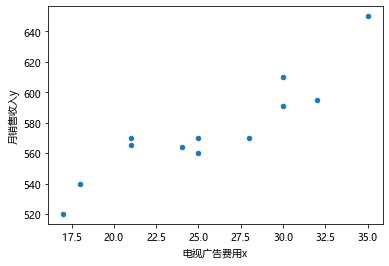

In [3]:
df1[:-1].plot(kind='scatter',x='电视广告费用x',y='月销售收入y')

### 计算相关系数

In [4]:
n = len(df1) - 1
_xy = n * df1.iloc[12,3] - df1.iloc[12,1] * df1.iloc[12,2]
_x = (n * df1.iloc[12,5] - df1.iloc[12,1] ** 2) ** 0.5
_y = (n * df1.iloc[12,4] - df1.iloc[12,2] ** 2) ** 0.5
r = _xy / (_x * _y)
print("相关系数为：" ,r)

# stats.peasonr(x,y)[0] 也可以计算相关系数

相关系数为： 0.907408389191994


pandas和scipy.stats.pearsonr()计算相关系数

In [5]:
df1[['电视广告费用x','月销售收入y']].iloc[:-1].corr() # 要去掉最后一行的总计
sts.pearsonr(df1['电视广告费用x'][:-1],df1['月销售收入y'][:-1])[0]

0.9074083891919941

由于 r = 0.91,接近1，故认为月销售收入与广告费用高度线性相关

## 2.回归分析
利用例9-1的数据，对其进行回归分析

In [6]:
model =  LinearRegression()
x = df1.iloc[:-1,1].values.reshape((-1,1))
y = df1.iloc[:-1,2].values
model.fit(x,y)

r_sq = model.score(x, y)
y_pred = model.predict(x)
Adjusted_R = 1 - (1 - r_sq) * (n - 1) / (n - 1 - 1)
S_e = (sum([(y_1 - y_2) ** 2 for y_1 , y_2 in zip(y, y_pred)]) / (n - 1 - 1)) ** 0.5

print(S_e)
print(Adjusted_R)
print(r_sq)

14.72369932922166
0.8057289832536096
0.8233899847760088


In [7]:
regression_res = pd.DataFrame(index=['Multiple','R Square','Adjusted','标准误差','观测值'],
                             data={'回归统计':[r,r_sq,Adjusted_R,S_e,n]})
regression_res

,回归统计
Multiple,0.907408
R Square,0.823390
Adjusted,0.805729
标准误差,14.723699
观测值,12.000000


### 方差分析

In [8]:
dfa = 1
dfb = n - 2
a = 0.05
y_mean = [y.mean()] * n

ssa = sum([(y_ - y_mean) ** 2 for y_, y_mean in zip(y_pred,y_mean)])
ssb = sum([(y_ - y_p) ** 2 for y_, y_p in zip(y,y_pred)])

msa = ssa / dfa
msb = ssb / dfb
F = msa / msb
f_ = sts.f.ppf(1 - a, dfa, dfb) # f临界值
p = 1 - sts.f.cdf(F, dfa, dfb) # p值

pd.DataFrame(index=['回归分析','残差','总计'],
                             data={'df':[dfa, dfb, dfa + dfb],
                                   'SS':[ssa, ssb, ssa + ssb],
                                   'MS':[msa, msb,np.nan],
                                   'F':[F,np.nan,np.nan],
                                   'P':[p,np.nan,np.nan],
                                   })

,df,SS,MS,F,P
回归分析,1,10107.043447,10107.043447,46.62193,0.000046
残差,10,2167.873219,216.787322,NaN,NaN
总计,11,12274.916667,NaN,NaN,NaN


### 回归系数的检验

In [9]:
X = sm.add_constant(x)
model1 = sm.OLS(y,X)
res = model1.fit()
params = res.params
std_errors = res.bse
t_stat = res.tvalues
p_value = res.pvalues
limit = res.conf_int()


pd.DataFrame(index = ['Intercept','X Variable 1'],
             data={'Coef':[params[0],params[1]],
                   '标准误差':[std_errors[0],std_errors[1]],
                   't Stat':[t_stat[0],t_stat[1]],
                   'P-value':[p_value[0],p_value[1]],
                   '下限 95%':[limit[0][0],limit[1][0]],
                   '上限 95%':[limit[0][1],limit[1][1]]})

,Coef,标准误差,t Stat,P-value,下限 95%,上限 95%
Intercept,438.581197,20.486045,21.408779,1.102082e-09,392.935445,484.226948
X Variable 1,5.366097,0.785893,6.828025,4.580176e-05,3.615018,7.117175


## 3.对Maospalace.excel中的数据进行一元回归分析。

In [10]:
data = pd.read_excel('Maospalace.xlsx')
data = data.iloc[:,:-2]
data

,Bowl Price,Bowls,Soda,Beer
0,9.3,391,313,90
1,9.1,418,326,100
2,8.5,459,358,115
3,9.5,424,331,81
4,8.7,447,380,89
...,...,...,...,...
181,8.5,447,380,103
182,9.4,404,327,81
183,9.9,408,310,61
184,8.0,457,356,82


### 牛肉面的价格和卖出的碗数之间的回归分析

In [11]:
x = data.iloc[:,0].values.reshape((-1,1))
y1 = data.iloc[:,1].values
X = sm.add_constant(x)

model = sm.OLS(y1, X)
res = model.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.504
Method:                 Least Squares   F-statistic:                     189.0
Date:                Thu, 09 Jun 2022   Prob (F-statistic):           4.75e-30
Time:                        19:57:35   Log-Likelihood:                -794.42
No. Observations:                 186   AIC:                             1593.
Df Residuals:                     184   BIC:                             1599.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        695.8741     19.491     35.703      0.000     657.420     734.328
x1           -29.5945      2.152    -13.749      0.000     -33.841     -25.348
==============================================================================
Omnibus:                       94.072   Durbin-Watson:                   2.044
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               11.702
Skew:                           0.068   Prob(JB):                      0.00288
Kurtosis:                       1.779   Cond. No.                         140.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$R^2=0.507$相关性较强，说明牛肉面都额单价与卖出的牛肉面的数量存在一定的线性相关关系，但不够明显

### 牛肉面的价格和卖出的Soda数量之间的回归分析

In [12]:
y2 = data.iloc[:,2].values
model2 = sm.OLS(y2, X)
res2 = model2.fit()
res2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.338
Model:                            OLS   Adj. R-squared:                  0.334
Method:                 Least Squares   F-statistic:                     93.74
Date:                Thu, 09 Jun 2022   Prob (F-statistic):           3.54e-18
Time:                        19:57:35   Log-Likelihood:                -824.55
No. Observations:                 186   AIC:                             1653.
Df Residuals:                     184   BIC:                             1660.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        562.3356     22.918     24.537      0.000     517.120     607.551
x1           -24.5046      2.531     -9.682      0.000     -29.498     -19.511
==============================================================================
Omnibus:                        7.250   Durbin-Watson:                   1.917
Prob(Omnibus):                  0.027   Jarque-Bera (JB):                4.092
Skew:                           0.154   Prob(JB):                        0.129
Kurtosis:                       2.342   Cond. No.                         140.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$R^2=0.338$相关性较弱，说明牛肉面都额单价与卖出的Soda数量可能存在一定的线性相关关系

### 牛肉面的价格和卖出的Beer数量之间的回归分析

In [13]:
y3 = data.iloc[:,3].values
model3 = sm.OLS(y3, X)
res3 = model3.fit()
res3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.038
Model:                            OLS   Adj. R-squared:                  0.032
Method:                 Least Squares   F-statistic:                     7.170
Date:                Thu, 09 Jun 2022   Prob (F-statistic):            0.00808
Time:                        19:57:35   Log-Likelihood:                -756.55
No. Observations:                 186   AIC:                             1517.
Df Residuals:                     184   BIC:                             1524.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        127.4591     15.901      8.016      0.000      96.088     158.830
x1            -4.7021      1.756     -2.678      0.008      -8.167      -1.238
==============================================================================
Omnibus:                       32.362   Durbin-Watson:                   2.020
Prob(Omnibus):                  0.000   Jarque-Bera (JB):                8.005
Skew:                           0.066   Prob(JB):                       0.0183
Kurtosis:                       1.992   Cond. No.                         140.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$R^2=0.038$相关性极其弱，说明牛肉面都额单价与卖出的Beer数量无关